,Description,Value
0,session_id,4438
1,Target,Survived
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(100000, 10)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


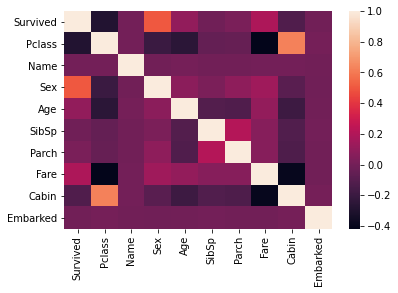

In [1]:
%matplotlib inline
from pycaret.classification import *
import matplotlib.pyplot as plt
import seaborn as sns
# import pyforest
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report,recall_score,precision_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import KFold,RandomizedSearchCV,train_test_split,cross_val_score
import lightgbm as lgb


#load the required datasets

df = pd.read_csv(r'C:\Users\USER\kagglesync\tabular-playground-series-apr-2021\train.csv')
df.drop(['PassengerId','Ticket'],axis=1,inplace=True)

##convert certain categorical data to numerical data
df['Sex'].replace('male',10,inplace=True)
df['Sex'].replace('female',20,inplace=True)
df['Embarked'].replace('C',50,inplace=True)
df['Embarked'].replace('S',60,inplace=True)
df['Embarked'].replace('Q',70,inplace=True)
##strip off special characters
df['Name'] = df['Name'].apply(lambda x:''.join([c for c in x if c.isalnum()]))
##convert to a iterale datatype (str)
df['Cabin'] = df['Cabin'].apply(lambda x : ''.join([i for i in str(x) if i.isalnum()]))
int_columns = ['Age','Fare']

##perform imputation on missing values in a numerical column
for col in int_columns:
  df[col].fillna(np.mean(df[col]),inplace=True)
df.fillna(-99999,axis=1,inplace=True)

##encode initially using label encoding
labelencoder = LabelEncoder()

df['Name'] = labelencoder.fit_transform(df['Name'])
df['Cabin'] = labelencoder.fit_transform(df['Cabin'])
##visualize the colinearity of the features
corre = df.corr()
sns.heatmap(corre)

X = df.drop(['Survived'],axis=1)
Y = df['Survived']
stdscale = StandardScaler()

##scale the dataset
X = pd.DataFrame(stdscale.fit_transform(X),columns=X.columns)
print(df.info())

#load the test set
df_test = pd.read_csv(r'C:\Users\USER\kagglesync\tabular-playground-series-apr-2021\test.csv')
##convert certain categorical data to numerical data

df_test.drop(['PassengerId','Ticket'],axis=1,inplace=True)

##convert certain categorical data to numerical data
df_test['Sex'].replace('male',10,inplace=True)
df_test['Sex'].replace('female',20,inplace=True)
df_test['Embarked'].replace('C',50,inplace=True)
df_test['Embarked'].replace('S',60,inplace=True)
df_test['Embarked'].replace('Q',70,inplace=True)
##strip special characters from each Name column instances
df_test['Name'] = df_test['Name'].apply(lambda x:''.join([x for c in x if c.isalnum()]))
df_test['Cabin'] = df_test['Cabin'].apply(lambda x : ''.join([i for i in str(x) if i.isalnum()]))

##perform imputation on missing values in a numerical column
for col in int_columns:
  df_test[col].fillna(np.mean(df_test[col]),inplace=True)
df_test.fillna(-1,axis=1,inplace=True)
df_test['Name'] = labelencoder.fit_transform(df_test['Name'])
df_test['Cabin'] = labelencoder.fit_transform(df_test['Cabin'])

##scale the dataset
A = stdscale.fit_transform(df_test)
print(df.info())
pycaret_set = setup(data=df,target='Survived')

In [2]:
best_model = compare_models(sort='Accuracy',n_select =3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7798,0.8493,0.7190,0.7546,0.7363,0.5475,0.5480,10.7490
lightgbm,Light Gradient Boosting Machine,0.7788,0.8505,0.7198,0.7523,0.7357,0.5457,0.5461,1.0460
catboost,CatBoost Classifier,0.7773,0.8487,0.7254,0.7467,0.7359,0.5435,0.5437,28.7170
ada,Ada Boost Classifier,0.7768,0.8428,0.7040,0.7571,0.7295,0.5400,0.5410,2.0050
rf,Random Forest Classifier,0.7611,0.8289,0.7024,0.7291,0.7155,0.5098,0.5100,6.1640
lda,Linear Discriminant Analysis,0.7596,0.8188,0.7179,0.7194,0.7186,0.5088,0.5088,0.3370
ridge,Ridge Classifier,0.7595,0.0000,0.7175,0.7194,0.7184,0.5085,0.5086,0.1050
et,Extra Trees Classifier,0.7539,0.8203,0.6972,0.7189,0.7079,0.4954,0.4956,7.7330
dt,Decision Tree Classifier,0.6897,0.6837,0.6418,0.6359,0.6388,0.3669,0.3669,0.4240
lr,Logistic Regression,0.6338,0.6733,0.3462,0.6136,0.4354,0.2039,0.2211,1.2270


In [3]:
##blend models using a soft voting classifier
blended = blend_models(estimator_list = best_model, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7831,0.8530,0.7235,0.7582,0.7405,0.5544,0.5549
1,0.7804,0.8524,0.7237,0.7530,0.7381,0.5491,0.5494
2,0.7769,0.8469,0.7164,0.7506,0.7331,0.5417,0.5421
3,0.7773,0.8496,0.7216,0.7486,0.7348,0.5430,0.5432
4,0.7814,0.8502,0.7264,0.7536,0.7397,0.5514,0.5517
Mean,0.7798,0.8504,0.7223,0.7528,0.7372,0.5479,0.5483
SD,0.0024,0.0022,0.0033,0.0032,0.0028,0.0049,0.0049


In [4]:
##tune the voted models
blend_tune = tune_model(blended
                     ,n_iter=50
                     , optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7789,0.8521,0.7247,0.7497,0.7370,0.5463,0.5466
1,0.7843,0.8544,0.7193,0.7627,0.7404,0.5561,0.5568
2,0.7774,0.8506,0.7113,0.7542,0.7321,0.5420,0.5427
3,0.7850,0.8548,0.7377,0.7541,0.7458,0.5596,0.5597
4,0.7723,0.8463,0.7137,0.7435,0.7283,0.5324,0.5328
5,0.7804,0.8482,0.7224,0.7538,0.7378,0.5491,0.5494
6,0.7736,0.8489,0.7150,0.7451,0.7298,0.5351,0.5354
7,0.7810,0.8514,0.7238,0.7543,0.7387,0.5504,0.5507
8,0.7804,0.8516,0.7211,0.7546,0.7375,0.5490,0.5494
9,0.7787,0.8495,0.7277,0.7479,0.7377,0.5463,0.5465


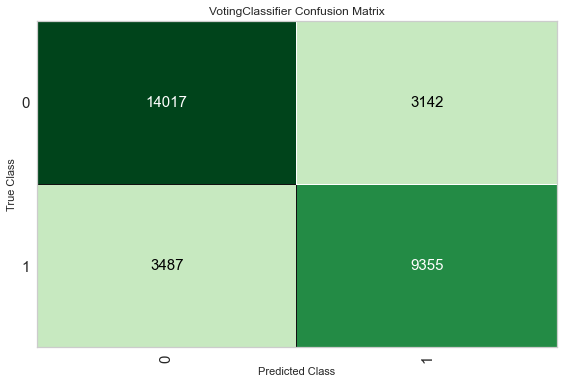

In [5]:
##show a confusion matrix for our models
plot_model(blend_tune, plot = 'confusion_matrix')

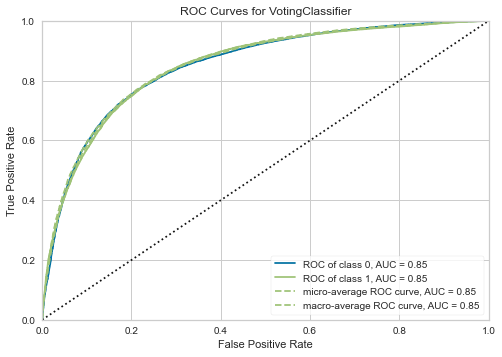

In [6]:
##graph out the auc curve
plot_model(blend_tune, plot = 'auc')

In [8]:
#make predictions
predictions = predict_model(blend_tune, data = df_test)
submission = pd.read_csv(r'C:\Users\USER\kagglesync\tabular-playground-series-apr-2021\sample_submission.csv')
submission['Survived'] = predictions['Label']
submission.to_csv(r'C:\Users\USER\kagglesync\tabular-playground-series-apr-2021\high2.csv',index=False)
predictions.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Label,Score
0,3,37448,10,19.0,0,0,63.01,25216,60.0,0,0.8449
1,3,58916,20,53.0,0,0,5.81,25216,60.0,1,0.7303
2,1,34253,20,19.0,0,0,38.91,8222,50.0,1,0.9256
3,2,45717,10,25.0,0,0,12.93,25216,60.0,0,0.6886
4,1,15261,20,17.0,0,2,26.89,10536,50.0,1,0.8445
